In [1]:
# import necessary libraries and specify that graphs should be plotted inline. 
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn import neighbors, datasets
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

### Data Exploration

In [2]:
#load dataset
from sklearn.datasets import load_breast_cancer
breast_cancer = load_breast_cancer()
df = pd.DataFrame(np.c_[breast_cancer['target'], breast_cancer['data']], columns=np.append(['MB'],breast_cancer['feature_names']))

# diagnosis
df['MB'] = df['MB'].replace('M',1) # M = malignant
df['MB'] = df['MB'].replace('B',0) # B = benign
df

,MB,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,0.0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,0.0,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,0.0,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,0.0,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,0.0,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,0.0,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,0.0,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,0.0,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,0.0,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


In [3]:
n_samples, n_features = breast_cancer.data.shape
print ('The dimensions of the data set are', n_samples, 'by', n_features)
print('The classes are: ', breast_cancer.target_names)
print('The features in the data set are:', breast_cancer.feature_names)

The dimensions of the data set are 569 by 30
The classes are:  ['malignant' 'benign']
The features in the data set are: ['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']


In [4]:
# Top3 Highest-correlated features
corr_matrix = df.corr()
top3_features = abs(corr_matrix['MB']).sort_values(ascending=False)[1:4]
top3_features 

worst concave points    0.793566
worst perimeter         0.782914
mean concave points     0.776614
Name: MB, dtype: float64

## Decision tree

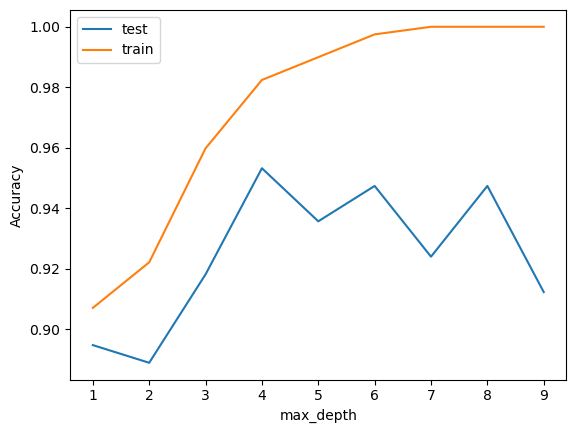

In [5]:
x = breast_cancer.data
y = breast_cancer.target

# Split the dataset into training(70%) and testing(30%) sets
X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.3, random_state=23)

# Train the models with max_depth in range(1,10) using training data
complexity_values = range(1,10)

train_accuracies = []
test_accuracies=[]

for complexity_value in complexity_values:
    clf = DecisionTreeClassifier(criterion="entropy", max_depth=complexity_value)
    test_accuracies.append(clf.fit(X_train, y_train).score(X_test, y_test))
    train_accuracies.append(clf.fit(X_train, y_train).score(X_train, y_train))
    
    
# plot the results
line1, =plt.plot(complexity_values, test_accuracies,label='test_accuracies')
line2, =plt.plot(complexity_values, train_accuracies,label='train_accuracies')
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.legend((line1, line2), ('test', 'train'))
plt.show()

As shown in the graph, when max_depth is 1, the model is **underfitting**. As max_depth increases from 2 to 4, both the train and test accuracies increase. When max_depth = 4, the model performs best in the testing data. However, when max_depth exceeds 4 and continues to increase, the training accuracy keeps improving, but the test accuracy starts to decline. This is a sign of **overfitting**.

In conclusion, 4 would be the optimal hyperparameter for the decision tree model.

In [6]:
# Build the final decision tree model.
clf = DecisionTreeClassifier(criterion="entropy", max_depth=4, random_state=23)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Evaluate performance by model goodness
tree_acc_scores = accuracy_score(y_test, y_pred)
print('Predictive Accuracy of decision tree model: ', tree_acc_scores)
print('\n')
print('Confusion matrix: \n', confusion_matrix(y_test, y_pred))
print('\n')
print('Classification report:''\n', classification_report(y_test, y_pred))

Predictive Accuracy of decision tree model:  0.9532163742690059


Confusion matrix: 
 [[ 57   6]
 [  2 106]]


Classification report:
               precision    recall  f1-score   support

           0       0.97      0.90      0.93        63
           1       0.95      0.98      0.96       108

    accuracy                           0.95       171
   macro avg       0.96      0.94      0.95       171
weighted avg       0.95      0.95      0.95       171



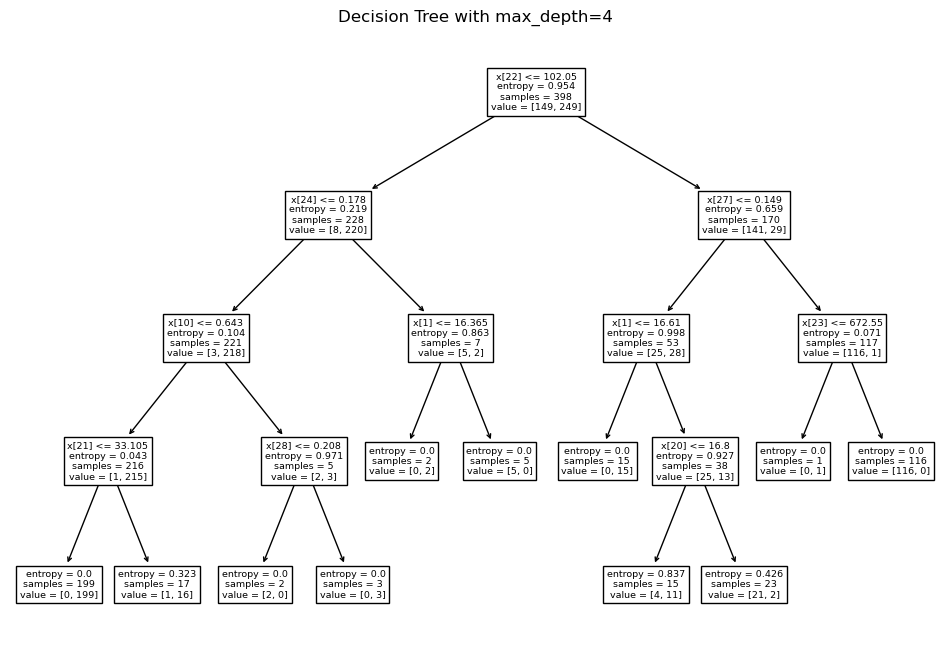

In [7]:
# plot the decision tree
plt.figure(figsize=(12, 8))
tree.plot_tree(clf)
plt.title(f"Decision Tree with max_depth=4")
plt.show()

## K-nearest Neighbors

In [8]:
# Standardize the features
scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)

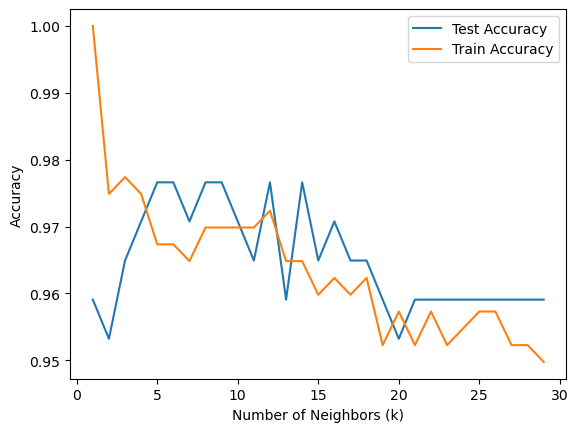

In [9]:
# Train the models with k in range(1,30) using training data
k_values = range(1, 30)  

train_accuracies = []
test_accuracies = []

# Iterate through each k value and train/test KNN models
for k in k_values:
    knn_classifier = KNeighborsClassifier(n_neighbors=k)
    knn_classifier.fit(X_train_normalized, y_train)
    
    train_acc = knn_classifier.score(X_train_normalized, y_train)
    test_acc = knn_classifier.score(X_test_normalized, y_test)
    
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

# Plot the training and testing accuracies
plt.plot(k_values, test_accuracies, label='Test Accuracy')
plt.plot(k_values, train_accuracies, label='Train Accuracy')
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

when k below 5, we observed the model is **overfitting** because the training accuracy is significantly higher than the testing accuracy and have large gap between them.
Since the overall accuracy is high, we can not observe any **underfitting**.

In [10]:
# Tuning hyperparameters in KNN
k_values = range(1, 30) 
param_grid = dict(n_neighbors = k_values)

# model
knn = KNeighborsClassifier()

# parameter search and scoring
knn_clf = GridSearchCV(estimator=knn, param_grid=param_grid, scoring='accuracy', cv=5)

# fit the models
knn_clf.fit(X_train_normalized, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(1, 30)}, scoring='accuracy')

In [11]:
print (knn_clf.best_score_)
print (knn_clf.best_params_)
print (knn_clf.best_estimator_)

0.957373417721519
{'n_neighbors': 14}
KNeighborsClassifier(n_neighbors=14)


In [12]:
y_pred = knn_classifier.predict(X_test_normalized)

# Evaluate performance by model goodness
knn_acc_scores = accuracy_score(y_test, y_pred)
conf_mtrx = confusion_matrix(y_test, y_pred)
cfr = classification_report(y_test, y_pred)

print('Prediction Accuracy of KNN model: ', knn_acc_scores)
print('\n')
print('Confusion matrix: \n', conf_mtrx)
print('\n')
print('Classification report:''\n', cfr)
print('\n') 

Prediction Accuracy of KNN model:  0.9590643274853801


Confusion matrix: 
 [[ 57   6]
 [  1 107]]


Classification report:
               precision    recall  f1-score   support

           0       0.98      0.90      0.94        63
           1       0.95      0.99      0.97       108

    accuracy                           0.96       171
   macro avg       0.96      0.95      0.96       171
weighted avg       0.96      0.96      0.96       171





## Logistic Regression

In [13]:
# Standardize the features
scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)

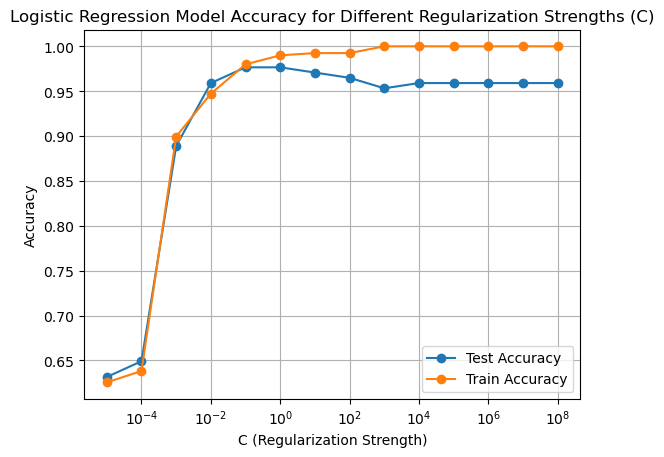

In [14]:
import matplotlib.pyplot as plt

# Define a list of regularization strengths (C values) to evaluate
C_values=[10**i for i in range(-5,9)] 

# Create empty lists to store accuracy scores
train_accuracies = []
test_accuracies = []

# Iterate through each C value
for C in C_values:
    logistic_regression = LogisticRegression(C=C, max_iter=1000)
    logistic_regression.fit(X_train_normalized, y_train)
    
    # Predict on training and test data
    y_train_pred = logistic_regression.predict(X_train_normalized)
    y_test_pred = logistic_regression.predict(X_test_normalized)
    
    # Calculate accuracy for both training and testing data
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

# Plot accuracy vs. C values
plt.semilogx(C_values, test_accuracies, label='Test Accuracy', marker='o')
plt.semilogx(C_values, train_accuracies, label='Train Accuracy', marker='o')
plt.xlabel('C (Regularization Strength)')
plt.ylabel('Accuracy')
plt.title('Logistic Regression Model Accuracy for Different Regularization Strengths (C)')
plt.legend()
plt.grid(True)
plt.show()

When C = 0.0001, we observe that the model is **underfitting** because both the training and testing accuracy are low.
Under these hyper-parameters, we did not observe any **overfitting** model.

In [15]:
# Tuning hyperparameters in Logistic Regression
c_values = [10**i for i in range(-5,9)]  #C
param_grid = dict(C = c_values)

lg = LogisticRegression()

In [16]:
grid = GridSearchCV(lg, param_grid, cv=5, scoring='accuracy')
grid.fit(X_train_normalized, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100,
                               1000, 10000, 100000, 1000000, 10000000,
                               100000000]},
             scoring='accuracy')

In [17]:
print (grid.best_score_)
print (grid.best_params_)
print (grid.best_estimator_)

0.9824367088607595
{'C': 1}
LogisticRegression(C=1)


In [18]:
lg_acc_scores = accuracy_score(y_test, grid.predict(X_test_normalized))
print("Prediction Accuracy for Logistic Regression model: ",lg_acc_scores)
print('\n')
print('Confusion matrix: \n', confusion_matrix(y_test, grid.predict(X_test_normalized)))
print('\n')
print('Classification report:''\n', classification_report(y_test, grid.predict(X_test_normalized)))
print('\n') 

Prediction Accuracy for Logistic Regression model:  0.9766081871345029


Confusion matrix: 
 [[ 60   3]
 [  1 107]]


Classification report:
               precision    recall  f1-score   support

           0       0.98      0.95      0.97        63
           1       0.97      0.99      0.98       108

    accuracy                           0.98       171
   macro avg       0.98      0.97      0.97       171
weighted avg       0.98      0.98      0.98       171





## Models Selection

In [19]:
# we use predictive accuracy to choose a model
model_acc = {}
model_acc['Decision Tree'] = tree_acc_scores
model_acc['KNN'] = knn_acc_scores
model_acc['Logistic Regression'] = lg_acc_scores
model_acc

{'Decision Tree': 0.9532163742690059,
 'KNN': 0.9590643274853801,
 'Logistic Regression': 0.9766081871345029}